# Recommendation module
## _still under construction_


In [1]:
import json, re
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import itertools


# === NLTK preprocessing ===
import nltk
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer, LancasterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet


nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mmart\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mmart\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mmart\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mmart\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# opcje przetwarzania naszych danych --> możliwe że zmienimy je w przyszłości w zależności od wyników, na początejk powiiny styknąć
PROCESSING_OPTS = {
    "use_stemmer": "porter",  # "porter" | "snowball" | None
    "use_lemmatizer": False,
    "lowercase": True,
    "min_df": 1,
    "max_df": 0.95,
    "ngram_range": (1, 2),
    "stop_words": "english",
}

In [3]:
# helpery do preprocessowania tekstu
def get_stemmer():
    mode = PROCESSING_OPTS.get("use_stemmer")
    if mode == "porter":
        return PorterStemmer()
    elif mode == "snowball":
        return SnowballStemmer("english")
    elif mode == "lancaster":
        return LancasterStemmer()
    else:
        return None


def get_lemmatizer():
    return WordNetLemmatizer() if PROCESSING_OPTS["use_lemmatizer"] else None

def preprocess_text(doc: str) -> str:
    if not isinstance(doc, str):
        return ""
    txt = doc.lower() if PROCESSING_OPTS["lowercase"] else doc
    tokens = word_tokenize(txt)
    stemmer = get_stemmer()
    lemm = get_lemmatizer()
    processed = []
    for t in tokens:
        if not t.isalpha():
            continue
        w = t
        if lemm:
            w = lemm.lemmatize(w)
        if stemmer:
            w = stemmer.stem(w)
        processed.append(w)
    return " ".join(processed)

In [4]:
# ładowanie danych roślinkowych z naszego jsona

def load_and_aggregate_json(path: str):
    with open(path, "r", encoding="utf-8") as f:
        js = json.load(f)
    df_raw = pd.DataFrame(js)
    if "plant_name" not in df_raw.columns or "content" not in df_raw.columns:
        raise ValueError("Brak wymaganych kolumn 'plant_name' i 'content'")
    df_agg = (
        df_raw.groupby("plant_name", as_index=False)
        .agg({"content": lambda s: "\n".join([x for x in s if isinstance(x, str)])})
    )
    return df_raw, df_agg


In [5]:
plant_path = "../plant_docs/plant_articles.json"
raw, agg = load_and_aggregate_json(plant_path)

In [6]:
print(f"We have {len(raw)} articles about plants.\n And {len(agg)} unique plants.")

We have 332 articles about plants.
 And 93 unique plants.


In [7]:
raw.head()

,plant_name,article_title,site,link,content
0,Peace Lily,No Peace Lily Blooms? Expert Tips For More Flo...,gardeningknowhow,https://www.gardeningknowhow.com/houseplants/p...,Why Your Peace Lily Won’t Bloom & Tips To Make...
1,Peace Lily,How to Keep Your Peace Lily Healthy,gardenersdream,https://www.gardenersdream.co.uk/blogs/gardene...,"As far as plants that are given as gifts go, t..."
2,Peace Lily,How to Grow and Care for a Peace Lily Plant In...,better home & gardens,https://www.bhg.com/gardening/plant-dictionary...,Peace lilies are hugely popular houseplants th...
3,Pothos,Pothos (Epipremnum aureum),costafarms,https://costafarms.com/blogs/plant-finder/poth...,Pothos Plant Features A perfect houseplant for...
4,Pothos,How to care for a pothos plant,houseandgarden,https://www.houseandgarden.co.uk/article/potho...,"Information Pothos Common names: Pothos, Devil..."


In [8]:
agg.head()

,plant_name,content
0,Aechmea fasciata,"Aechmea Fasciata: Urn Plant, Vase Plant Care T..."
1,Air Plant,Air plants (Tillandsia spp) are unique and fas...
2,Alocasia Polly,My African Mask Plant sits on a long table in ...
3,Aloe vera,How to Care for Aloe Vera Plants: Easy Guide t...
4,Anthurium,"Like any supermodel, these fabulously fiery “f..."


In [9]:
agg.loc[0, 'content']

'Aechmea Fasciata: Urn Plant, Vase Plant Care Tips Are you ready to add a touch of tropical pizazz to your indoor garden? Look no further than the stunning Aechmea fasciata, which may soon become your favorite bromeliad. These plant care tips will help keep yours healthy and looking good. Bromeliads have rocked my world for many years, so I share the love today. The Aechmea fasciata, with its patterned silver foliage and pink flower, makes a great houseplant and will have beginning gardeners singing “green thumb” in no time. I started my horticultural career as an interior landscape technician, maintaining plants in lobbies, malls, offices, and hotels. Granted, these aren’t the most welcoming environments for flowering plants native to the tropics and the subtropics, but bromeliads held their own. This Aechmea was commonly used, and their pink blooms were long-lasting. Botanical Name: Aechmea fasciata Common Names: Vase Plant, Silver Vase Plant, Urn PlantAechmea Fasciata Plant Care Tip

In [10]:
len(agg.loc[0, 'content'])

17842

In [11]:
raw.iloc[0]

plant_name                                              Peace Lily
article_title    No Peace Lily Blooms? Expert Tips For More Flo...
site                                              gardeningknowhow
link             https://www.gardeningknowhow.com/houseplants/p...
content          Why Your Peace Lily Won’t Bloom & Tips To Make...
Name: 0, dtype: object

In [12]:
x = raw[raw['plant_name'] == 'Aloe vera']
x

,plant_name,article_title,site,link,content
46,Aloe vera,How to Care for Aloe Vera Plants,almanac,https://www.almanac.com/plant/aloe-vera,How to Care for Aloe Vera Plants: Easy Guide t...
47,Aloe vera,Plant Spotlight: Aloe Vera,plantstore,https://www.plantstore.ie/blogs/news/plant-spo...,"Plant Spotlight: Aloe Vera March 30, 2021 Kate..."
48,Aloe vera,An aloe-killer’s guide to thriving aloe vera p...,gardenstead,https://www.gardenstead.com/an-aloe-killers-gu...,An aloe-killer’s guide to thriving aloe vera p...


In [13]:
lengths = x['content'].apply(len)
print(f"Lengths of content for 'Aloe vera' rows separately\n: {lengths}")
print(f"Total length: {lengths.sum()}") #my sanity check to confirm aggregation is correct --> it shall give us not the 
# same vales since in agg we add blank spaces and newlines between articles

Lengths of content for 'Aloe vera' rows separately
: 46    11894
47     5205
48     9934
Name: content, dtype: int64
Total length: 27033


In [14]:
# --- TF-IDF ---
def build_tfidf_matrix(df_agg: pd.DataFrame):
    vectorizer = TfidfVectorizer(
        preprocessor=preprocess_text,
        tokenizer=None,
        lowercase=False,
        min_df=PROCESSING_OPTS["min_df"],
        max_df=PROCESSING_OPTS["max_df"],
        ngram_range=PROCESSING_OPTS["ngram_range"],
        stop_words=PROCESSING_OPTS["stop_words"],
    )
    matrix = vectorizer.fit_transform(df_agg["content"].fillna(""))
    plant_names = df_agg["plant_name"].tolist()
    return vectorizer, matrix, plant_names


In [15]:
def get_centroid_vector(seed_plants: List[str], matrix, plant_names):
    idx = [plant_names.index(p) for p in seed_plants if p in plant_names]
    if not idx:
        raise ValueError("Brak znanych roślin w seedach.")
    sub = matrix[idx]
    centroid = sub.sum(axis=0) / len(idx)
    centroid = np.asarray(centroid)
    if centroid.ndim == 1:
        centroid = centroid[None, :]
    return centroid


In [16]:
def get_similar_plants(seed_plants, matrix, plant_names, top_k=10, exclude_seeds=True):
    centroid = get_centroid_vector(seed_plants, matrix, plant_names)
    sims = cosine_similarity(centroid, matrix)[0]
    order = np.argsort(-sims)
    exclude = set(seed_plants) if exclude_seeds else set()
    results = []
    for i in order:
        name = plant_names[i]
        if name in exclude:
            continue
        results.append((name, float(sims[i])))
        if len(results) >= top_k:
            break
    return results

In [17]:
# # cechy do mapowania -- wybrania przez użytkownika
# LIGHT_MAP = {
#     r"low light|shade|shady|little light|no direct": "low",
#     r"bright( indirect)? light|indirect light|filtered light|east(-|\s)?facing|north(-|\s)?facing": "medium",
#     r"bright direct|full sun|south(-|\s)?facing": "high",
# }
# WATER_MAP = {
#     r"let (the )?soil dry|drought tolerant|rare(ly)? water|infrequent watering|overwater": "low",
#     r"moderate watering|allow top inch to dry|weekly watering|water when top": "medium",
#     r"keep (soil|substrate) (evenly )?moist|frequent watering": "high",
# }
# HUMIDITY_MAP = {
#     r"low humidity|dry air": "low",
#     r"average humidity|normal household humidity": "medium",
#     r"high humidity|humid environment|bathroom|terrarium|misting": "high",
# }
# TOXIC_MAP = {
#     r"toxic|poisonous|keep away from pets|irritant|calcium oxalate": "toxic",
#     r"non[-\s]?toxic|pet[-\s]?safe|safe for pets|nontoxic": "safe",
# }
# DIFFICULTY_MAP = {
#     r"easy|beginner[-\s]?friendly|for beginners|hardy|tolerant": "easy",
#     r"intermediate|moderate care|some experience": "medium",
#     r"advanced|tricky|challenging|demanding": "hard",
# }

In [18]:
#nowe cechy do mapowania --- 16.11
# Light:
# - "partial / dappled shade" → medium
# - "bright indirect", "east-facing" → medium
# - "full sun", "south-facing" → high
LIGHT_MAP = {
    r"low light|very low light|shade|shady|little light|no direct": "low",
    r"partial shade|dappled shade|indirect light|bright( but)? indirect light|"
    r"filtered light|east(-|\s)?facing|north(-|\s)?facing": "medium",
    r"bright direct( sunlight)?|full sun|south(-|\s)?facing|"
    r"at least (4|5|6)\+?\s*hours of sun": "high",
}

# Water:
# - succulents/cacti usually → low
# - “keep soil evenly moist” → high
WATER_MAP = {
    r"succulent|cactus|let (the )?soil (completely )?dry|drought tolerant|"
    r"tolerates drought|infrequent watering|water sparingly": "low",
    r"moderate watering|allow top( few)? inch(es)? to dry|weekly watering|"
    r"when the top (inch|layer) feels dry": "medium",
    r"keep (soil|substrate) (evenly )?moist|constantly moist|frequent watering|"
    r"do not let (the )?soil dry out": "high",
}

HUMIDITY_MAP = {
    r"tolerates dry air|low humidity|radiator|central heating": "low",
    r"average humidity|normal household humidity|room humidity": "medium",
    r"high humidity|humid environment|bathroom plant|terrarium|"
    r"misting|frequent misting|use a humidifier": "high",
}

# IMPORTANT: 'safe' patterns must go BEFORE 'toxic' to avoid matching 'toxic' inside 'non-toxic'.
TOXIC_MAP = {
    r"non[-\s]?toxic|not toxic|pet[-\s]?safe|safe for (cats|dogs|pets)|nontoxic": "safe",
    r"\btoxic\b|\bpoisonous\b|keep away from pets|irritant|calcium oxalate|"
    r"causes (irritation|upset stomach|vomiting)": "toxic",
}

DIFFICULTY_MAP = {
    r"very easy|super easy|beginner[-\s]?friendly|for beginners|"
    r"low[-\s]?maintenance|hardy|tolerant|for busy people": "easy",
    r"intermediate|moderate care|required care|some experience": "medium",
    r"advanced|tricky|challenging|demanding|requires attention": "hard",
}

In [19]:
#new extract trait logic --- 16.11
def extract_trait(text: str, mapping: Dict[str, str], default=None):
    t = (text or "").lower()
    for pattern, value in mapping.items():
        if re.search(pattern, t):
            return value
    return default

In [20]:
# def extract_trait(text: str, mapping: Dict[str, str], default=None):
#     t = (text or "").lower()
#     for pattern, value in mapping.items():
#         if re.search(pattern, t):
#             return value
#     return default

def parse_traits_from_text(text: str):
    return {
        "light": extract_trait(text, LIGHT_MAP),
        "water": extract_trait(text, WATER_MAP),
        "humidity": extract_trait(text, HUMIDITY_MAP),
        "toxicity": extract_trait(text, TOXIC_MAP),
        "difficulty": extract_trait(text, DIFFICULTY_MAP),
    }

# def build_traits_table(df_raw: pd.DataFrame):
#     rows = []
#     for _, row in df_raw.iterrows():
#         pn, ct = row.get("plant_name"), row.get("content")
#         if isinstance(pn, str) and isinstance(ct, str):
#             rows.append({"plant_name": pn, **parse_traits_from_text(ct)})
#     df_traits = pd.DataFrame(rows)
#     df_traits = df_traits.groupby("plant_name", as_index=False).agg(lambda s: s.dropna().iloc[0] if s.dropna().size else None)
#     return df_traits


In [21]:
# new build traits table --- 16.11 with using majority voting
# basically handling different information in the articles about the same plant
# for example one plant articles might say it needs low light, other that it needs medium light
# so we take the most frequent value among articles for each trait
def majority_or_first(s: pd.Series):
    s = s.dropna()
    if s.empty:
        return None
    counts = s.value_counts()
    # highest count wins; if tie, pandas keeps a deterministic order
    return counts.index[0]

def build_traits_table(df_raw: pd.DataFrame):
    rows = []
    for _, row in df_raw.iterrows():
        pn, ct = row.get("plant_name"), row.get("content")
        if isinstance(pn, str) and isinstance(ct, str):
            traits = parse_traits_from_text(ct)
            rows.append({"plant_name": pn, **traits})
    df_traits = pd.DataFrame(rows)
    df_traits = (
        df_traits
        .groupby("plant_name", as_index=False)
        .agg(majority_or_first)
    )
    return df_traits

In [22]:
# REKOMENDACJE
@dataclass
class UserConstraints:
    light: Optional[str] = None
    water: Optional[str] = None
    humidity: Optional[str] = None
    pets_safe: Optional[bool] = None
    difficulty: Optional[str] = None

WEIGHTS = {"light": 2.0, "water": 1.5, "humidity": 1.0, "difficulty": 0.5}

def score_constraints(plant_name, df_traits, constraints: UserConstraints):
    row = df_traits[df_traits["plant_name"] == plant_name]
    if row.empty:
        return 0.0
    r = row.iloc[0].to_dict()

    if constraints.pets_safe and r.get("toxicity") == "toxic":
        return -1e9
    score = 0.0
    if constraints.light and r.get("light") == constraints.light:
        score += WEIGHTS["light"]
    if constraints.water and r.get("water") == constraints.water:
        score += WEIGHTS["water"]
    if constraints.humidity and r.get("humidity") == constraints.humidity:
        score += WEIGHTS["humidity"]
    if constraints.difficulty and r.get("difficulty") == constraints.difficulty:
        score += WEIGHTS["difficulty"]
    return score


def recommend_by_constraints(df_agg, df_traits, constraints: UserConstraints, top_k=10):
    names = df_agg["plant_name"].tolist()
    scores = [(n, score_constraints(n, df_traits, constraints)) for n in names]
    scores = [x for x in scores if x[1] > -1e8]
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[:top_k]


def hybrid_recommend(seed_plants, matrix, plant_names, df_agg, df_traits, constraints=None, alpha=0.6, top_k=10):
    sims = get_similar_plants(seed_plants, matrix, plant_names, top_k=len(df_agg), exclude_seeds=True)
    if not constraints:
        return sims[:top_k]

    denom = sum(WEIGHTS.values())
    rescored = []
    for name, sim in sims:
        cscore = score_constraints(name, df_traits, constraints)
        if cscore <= -1e8:
            continue
        final = alpha * sim + (1 - alpha) * (cscore / denom)
        rescored.append((name, float(final)))
    rescored.sort(key=lambda x: x[1], reverse=True)
    return rescored[:top_k]



In [23]:
# if __name__ == "__main__":
#     df_raw, df_agg = load_and_aggregate_json(plant_path)
#     df_traits = build_traits_table(df_raw)

#     vectorizer, matrix, plant_names = build_tfidf_matrix(df_agg)

#     seeds = df_agg["plant_name"].head(2).tolist()
#     print("Similar:", get_similar_plants(seeds, matrix, plant_names, top_k=5))

#     uc = UserConstraints(light="low", water="low", pets_safe=True)
#     print("By constraints:", recommend_by_constraints(df_agg, df_traits, uc, top_k=5))
#     print("Hybrid:", hybrid_recommend(seeds, matrix, plant_names, df_agg, df_traits, uc, top_k=5))

In [24]:
df_raw, df_agg = load_and_aggregate_json(plant_path)
df_traits = build_traits_table(df_raw)
vectorizer, matrix, plant_names = build_tfidf_matrix(df_agg)

print("✅ Dane załadowane:")
print(f"- liczba roślin: {len(plant_names)}")
print(f"- kształt macierzy TF-IDF: {matrix.shape}")

# test podobnych roślin
seeds = ["Aloe vera", "Peace Lily"]  # albo inne, które masz w pliku
similar = get_similar_plants(seeds, matrix, plant_names, top_k=5)
print("\n🌿Similiar to plants", seeds, ":")
for n, s in similar:
    print(f"  {n:25s} | similarity={s:.3f}")

# test warunków
uc = UserConstraints(light="low", water="low", pets_safe=True)
by_constraints = recommend_by_constraints(df_agg, df_traits, uc, top_k=5)
print("\n🌤️For Conditrions (low light, low water, pets safe):")
for n, s in by_constraints:
    print(f"  {n:25s} | score={s:.2f}")

# test hybrydy
hyb = hybrid_recommend(seeds, matrix, plant_names, df_agg, df_traits, uc, top_k=5)
print("\n🌱Hybrid:")
for n, s in hyb:
    print(f"  {n:25s} | final_score={s:.3f}")

c:\Users\mmart\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yoursel

✅ Dane załadowane:
- liczba roślin: 93
- kształt macierzy TF-IDF: (93, 106390)

🌿Similiar to plants ['Aloe vera', 'Peace Lily'] :
  Haworthia Fasciata        | similarity=0.065
  Dieffenbachia             | similarity=0.042
  Spider plant              | similarity=0.036
  Snake plant               | similarity=0.035
  String of Pearls          | similarity=0.028

🌤️For Conditrions (low light, low water, pets safe):
  Asplenium nidus           | score=3.50
  Chamaedorea Elegans       | score=3.50
  Chamomile                 | score=3.50
  Chinese money plant       | score=3.50
  Christmas Cactus          | score=3.50

🌱Hybrid:
  Haworthia Fasciata        | final_score=0.319
  Snake plant               | final_score=0.301
  Christmas Cactus          | final_score=0.297
  Echeveria Elegans         | final_score=0.295
  Echeveria agavoides       | final_score=0.293


-------

Debugging to see what traits are asigned for a plant

In [25]:
def debug_traits_for_plant(plant_name: str, df_raw: pd.DataFrame):
    subset = df_raw[df_raw["plant_name"] == plant_name]
    print(f"== {plant_name} ({len(subset)} articles) ==")
    for i, row in subset.reset_index(drop=True).iterrows():
        print(f"\n--- Article {i+1} ---")
        traits = parse_traits_from_text(row["content"] or "")
        print("Extracted traits:", traits)
        # show short preview
        preview = (row["content"] or "")[:400].replace("\n", " ")
        print("Preview:", preview, "...")


In [26]:
debug_traits_for_plant("Aloe vera", df_raw)


== Aloe vera (3 articles) ==

--- Article 1 ---
Extracted traits: {'light': 'low', 'water': 'low', 'humidity': None, 'toxicity': 'toxic', 'difficulty': 'easy'}
Preview: How to Care for Aloe Vera Plants: Easy Guide to Growing Aloe Indoors & Out green aloe vera plant in a white pot with a wooden wall background Photo Credit Sunwand24/Shutterstock Botanical Name Aloe vera Plant Type Cacti/Succulents Sun Exposure Full Sun Part Sun Soil pH Neutral Bloom Time Spring Summer Fall Flower Color Orange Pink Red Yellow Hardiness Zone 10 11 Subhead Growing Aloe Vera Plants: W ...

--- Article 2 ---
Extracted traits: {'light': 'low', 'water': 'low', 'humidity': None, 'toxicity': None, 'difficulty': None}
Preview: Plant Spotlight: Aloe Vera March 30, 2021 Kate Higham This popular, happy-go-lucky indoor plant, quite frankly, had us at Aloe (sorry, we had to!) Aloe Vera, also known by its botanical name “Aloe barbadensis”, is a succulent family member with over 300 species found worldwide. This desert-

need to verify the results further on for clarity and thesis purpose to have good explanations

-----

## Testing different processing options - stemmers and lemmatizers

In [27]:
STEMMER_CONFIGS = [
    {
        "name": "porter_only",
        "use_stemmer": "porter",
        "use_lemmatizer": False,
    },
    {
        "name": "snowball_only",
        "use_stemmer": "snowball",
        "use_lemmatizer": False,
    },
    {
        "name": "lancaster_only",
        "use_stemmer": "lancaster",
        "use_lemmatizer": False,
    },
    {
        "name": "lemmatizer_only",
        "use_stemmer": None,
        "use_lemmatizer": True,
    },
    {
        "name": "porter_plus_lemm",
        "use_stemmer": "porter",
        "use_lemmatizer": True,
    },
    {
        "name": "no_stem_no_lemm",
        "use_stemmer": None,
        "use_lemmatizer": False,
    },
]


In [28]:
def apply_processing_config(config: Dict):
    PROCESSING_OPTS["use_stemmer"] = config["use_stemmer"]
    PROCESSING_OPTS["use_lemmatizer"] = config["use_lemmatizer"]


In [29]:
def build_model_for_config(config: Dict, df_agg: pd.DataFrame):
    apply_processing_config(config)
    vectorizer, matrix, plant_names = build_tfidf_matrix(df_agg)
    return {
        "config": config,
        "vectorizer": vectorizer,
        "matrix": matrix,
        "plant_names": plant_names,
    }


In [30]:
TEST_SEED_SETS = [
    ["Aloe vera"],
    ["Peace Lily"],
    ["Snake Plant"],
    ["Aloe vera", "Peace Lily"],
    ["Spider Plant", "Snake Plant"],
    ["Rattlesnake Plant"],
    ["Rattlesnake Plant", "Snake Plant"],
    ["Fiddle Leaf Fig", "Ficus lyrata"],
    ["Mint", "Basil"]
]
TOP_K_TEST = 10


In [31]:
def jaccard_plant_lists(rec_a, rec_b):
    """
    rec_a, rec_b: lists of (plant_name, score).
    Returns Jaccard similarity of the name sets.
    """
    set_a = {name for name, _ in rec_a}
    set_b = {name for name, _ in rec_b}
    if not set_a and not set_b:
        return 1.0
    if not set_a or not set_b:
        return 0.0
    return len(set_a & set_b) / len(set_a | set_b)


In [32]:
experiment_results = {}

for cfg in STEMMER_CONFIGS:
    model = build_model_for_config(cfg, df_agg)
    matrix_c = model["matrix"]
    plant_names_c = model["plant_names"]
    cfg_name = cfg["name"]
    experiment_results[cfg_name] = {}

    for seeds in TEST_SEED_SETS:
        # filter out seeds that might be missing
        valid_seeds = [s for s in seeds if s in plant_names_c]
        if not valid_seeds:
            continue
        recs = get_similar_plants(valid_seeds, matrix_c, plant_names_c, top_k=TOP_K_TEST)
        experiment_results[cfg_name][tuple(seeds)] = recs

# Compare configs pairwise
cfg_names = list(experiment_results.keys())

print("\n=== Jaccard overlaps between configs (per seed set) ===")
for seeds in TEST_SEED_SETS:
    print(f"\nSeed set: {seeds}")
    for i in range(len(cfg_names)):
        for j in range(i+1, len(cfg_names)):
            cfg_i = cfg_names[i]
            cfg_j = cfg_names[j]
            rec_i = experiment_results[cfg_i].get(tuple(seeds), [])
            rec_j = experiment_results[cfg_j].get(tuple(seeds), [])
            jac = jaccard_plant_lists(rec_i, rec_j)
            print(f"  {cfg_i:18s} vs {cfg_j:18s} -> Jaccard={jac:.2f}")


c:\Users\mmart\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yoursel


=== Jaccard overlaps between configs (per seed set) ===

Seed set: ['Aloe vera']
  porter_only        vs snowball_only      -> Jaccard=1.00
  porter_only        vs lancaster_only     -> Jaccard=0.82
  porter_only        vs lemmatizer_only    -> Jaccard=0.82
  porter_only        vs porter_plus_lemm   -> Jaccard=1.00
  porter_only        vs no_stem_no_lemm    -> Jaccard=0.82
  snowball_only      vs lancaster_only     -> Jaccard=0.82
  snowball_only      vs lemmatizer_only    -> Jaccard=0.82
  snowball_only      vs porter_plus_lemm   -> Jaccard=1.00
  snowball_only      vs no_stem_no_lemm    -> Jaccard=0.82
  lancaster_only     vs lemmatizer_only    -> Jaccard=0.82
  lancaster_only     vs porter_plus_lemm   -> Jaccard=0.82
  lancaster_only     vs no_stem_no_lemm    -> Jaccard=0.82
  lemmatizer_only    vs porter_plus_lemm   -> Jaccard=0.82
  lemmatizer_only    vs no_stem_no_lemm    -> Jaccard=0.82
  porter_plus_lemm   vs no_stem_no_lemm    -> Jaccard=0.82

Seed set: ['Peace Lily']
  porte

In [33]:
def basic_sanity_checks():
    for cfg in STEMMER_CONFIGS:
        model = build_model_for_config(cfg, df_agg)
        m = model["matrix"]
        pn = model["plant_names"]

        assert m.shape[0] == len(pn), f"Rows and plant_names mismatch for {cfg['name']}"
        assert m.shape[0] > 0, f"No rows in matrix for {cfg['name']}"
        assert m.shape[1] > 0, f"No features in matrix for {cfg['name']}"

    print("✅ Basic sanity checks passed for all stemming configs.")

basic_sanity_checks()


c:\Users\mmart\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yoursel

✅ Basic sanity checks passed for all stemming configs.


In [34]:
rows = []

for seeds in TEST_SEED_SETS:
    seeds_key = tuple(seeds)
    seeds_label = ", ".join(seeds)
    for cfg_i, cfg_j in itertools.combinations(cfg_names, 2):
        rec_i = experiment_results[cfg_i].get(seeds_key, [])
        rec_j = experiment_results[cfg_j].get(seeds_key, [])
        jac = jaccard_plant_lists(rec_i, rec_j)
        rows.append({
            "seed_set": seeds_label,
            "cfg_i": cfg_i,
            "cfg_j": cfg_j,
            "jaccard": jac,
        })

df_jac = pd.DataFrame(rows)
df_jac.head()

,seed_set,cfg_i,cfg_j,jaccard
0,Aloe vera,porter_only,snowball_only,1.000000
1,Aloe vera,porter_only,lancaster_only,0.818182
2,Aloe vera,porter_only,lemmatizer_only,0.818182
3,Aloe vera,porter_only,porter_plus_lemm,1.000000
4,Aloe vera,porter_only,no_stem_no_lemm,0.818182


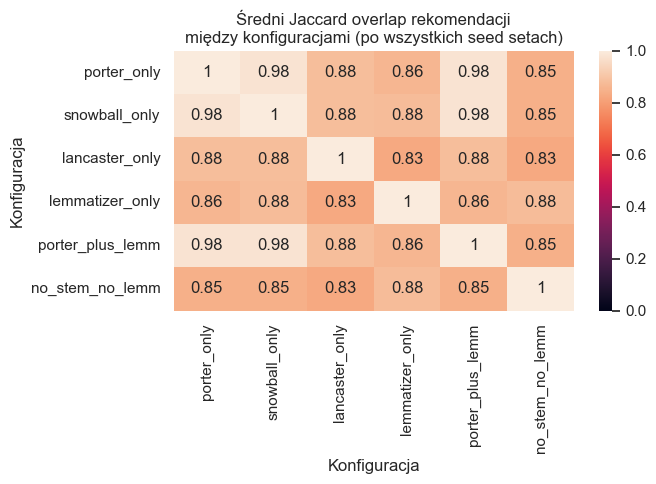

In [35]:
# średnie Jaccardy po wszystkich seed setach
df_jac_mean = (
    df_jac
    .groupby(["cfg_i", "cfg_j"], as_index=False)["jaccard"]
    .mean()
)

# zbudowanie pełnej macierzy (w tym przekątnej = 1.0)
jac_matrix = pd.DataFrame(
    index=cfg_names,
    columns=cfg_names,
    dtype=float
)

for cfg in cfg_names:
    jac_matrix.loc[cfg, cfg] = 1.0  # perfect overlap with itself

for _, row in df_jac_mean.iterrows():
    i = row["cfg_i"]
    j = row["cfg_j"]
    v = row["jaccard"]
    jac_matrix.loc[i, j] = v
    jac_matrix.loc[j, i] = v  # macierz symetryczna

plt.figure(figsize=(7, 5))
sns.heatmap(
    jac_matrix.astype(float),
    annot=True,
    vmin=0.0,
    vmax=1.0,
    cmap="rocket"
)
plt.title("Średni Jaccard overlap rekomendacji\nmiędzy konfiguracjami (po wszystkich seed setach)")
plt.xlabel("Konfiguracja")
plt.ylabel("Konfiguracja")
plt.tight_layout()
plt.show()

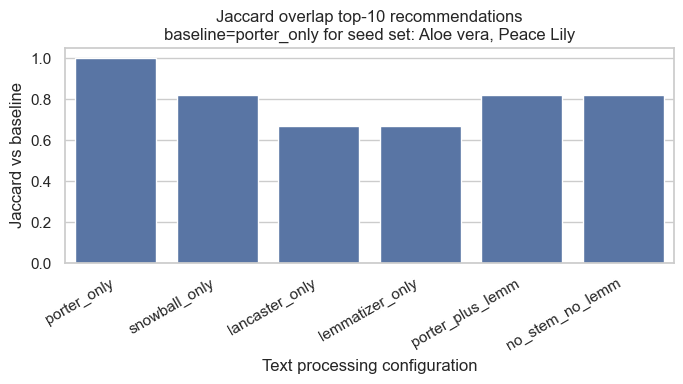

In [36]:
BASELINE_CFG = "porter_only"
SEED_SET_FOR_PLOT = ["Aloe vera", "Peace Lily"] 

seed_label = ", ".join(SEED_SET_FOR_PLOT)
seed_key = tuple(SEED_SET_FOR_PLOT)

baseline_recs = experiment_results[BASELINE_CFG].get(seed_key, [])

rows_seed = []
for cfg in cfg_names:
    recs = experiment_results[cfg].get(seed_key, [])
    jac = jaccard_plant_lists(baseline_recs, recs)
    rows_seed.append({"config": cfg, "jaccard_vs_baseline": jac})

df_seed = pd.DataFrame(rows_seed)

plt.figure(figsize=(7, 4))
sns.barplot(
    data=df_seed,
    x="config",
    y="jaccard_vs_baseline"
)
plt.ylim(0, 1.05)
plt.title(f"Jaccard overlap top-{TOP_K_TEST} recommendations\n"
          f"baseline={BASELINE_CFG} for seed set: {seed_label}")
plt.xlabel("Text processing configuration")
plt.ylabel("Jaccard vs baseline")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


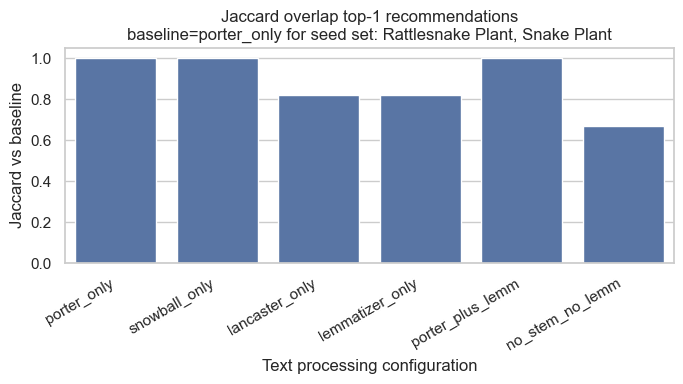

In [41]:
BASELINE_CFG = "porter_only"
SEED_SET_FOR_PLOT = TEST_SEED_SETS[6] 
TOP_K_TEST = 1
seed_label = ", ".join(SEED_SET_FOR_PLOT)
seed_key = tuple(SEED_SET_FOR_PLOT)

baseline_recs = experiment_results[BASELINE_CFG].get(seed_key, [])

rows_seed = []
for cfg in cfg_names:
    recs = experiment_results[cfg].get(seed_key, [])
    jac = jaccard_plant_lists(baseline_recs, recs)
    rows_seed.append({"config": cfg, "jaccard_vs_baseline": jac})

df_seed = pd.DataFrame(rows_seed)

plt.figure(figsize=(7, 4))
sns.barplot(
    data=df_seed,
    x="config",
    y="jaccard_vs_baseline"
)
plt.ylim(0, 1.05)
plt.title(f"Jaccard overlap top-{TOP_K_TEST} recommendations\n"
          f"baseline={BASELINE_CFG} for seed set: {seed_label}")
plt.xlabel("Text processing configuration")
plt.ylabel("Jaccard vs baseline")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()
